# Vanilla Model with Tensorflow and Keras

This model endeavors to reproduce what we did with fast.ai in TensorFlow so that we can use TensorFlow.js

Source: [here](https://www.tensorflow.org/alpha/tutorials/images/transfer_learning)

## Imports

In [48]:
from __future__ import absolute_import, division, print_function

import os
import re

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
print("TensorFlow version is ", tf.__version__)

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

TensorFlow version is  1.13.1


Using TensorFlow backend.


## Data preprocessing
Here we need to get the data we want to use and format it properly.

In [11]:
# data_root = tf.keras.utils.get_file(origin='http://data.vision.ee.ethz.ch/cvl/gfanelli/kinect_head_pose_db.tgz', 
#                                     fname='head_pose', untar=True)

6014402560/6014398431 [==============================] - 1593s 0us/step


Note that here we have to hard-code in the data_path, because the data_root is not quite right (not really sure why...)

In [0]:
data_path = '/root/.keras/datasets/hpdb/'

In [8]:
cal = np.genfromtxt(data_path + '01/rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

Now, let us create methods to actually extract the center of the image and try it out

In [0]:
def img2txt_name(f): 
  return data_path + str(f)[:-7] + 'pose.txt'

def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return np.array([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)
  
def get_scaled_center(f, width, height):
  img = cv2.imread(data_path + f)
  pt = get_ctr(f)
  return np.array([pt[0] * (width / img.shape[0]), pt[1] * (height / img.shape[1])])

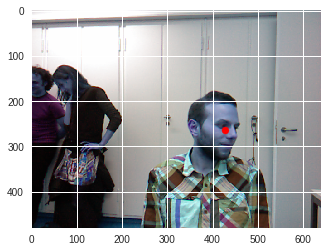

In [19]:
fname = '09/frame_00667_rgb.png'
img = cv2.imread(data_path + fname)
plt.imshow(img)
ctr = get_scaled_center(fname, img.shape[0], img.shape[1])
plt.scatter([ctr[1]], [ctr[0]], c='r')

## Create Training and Validation Arrays
Note that right now, the data from directory 13 is being used for validation because that's what was used in the fast.ai course. This can always be changed later.

In [0]:
valid_dirs = ['13']
train_dirs = [dir for dir in os.listdir(data_path) if len(dir) == 2 and dir not in valid_dirs]

In [0]:
def extract_from_dir(dir, width, height):
  # Extract image filenames (we are only using some to reduce RAM usage)
  pattern = re.compile('.*png')
  all_img_fns = [dir + '/' + fn for fn in os.listdir(data_path + dir) if pattern.match(fn)]
  img_fns = np.random.choice(np.array(all_img_fns), size=100, replace=False)
  
  # Now build the x and y arrays
  
  # First declare them, so we won't have to resize anything
  X = np.zeros((len(img_fns), height, width, 3)).astype(int)
  y = np.zeros((len(img_fns), 2)).astype(int)
  
  # Now fill in the arrays
  for i in range(len(img_fns)):
    img = cv2.imread(data_path + img_fns[i])
    X[i] = cv2.resize(img, (width, height))
    y[i] = get_scaled_center(img_fns[i], width, height)
    
  return X, y

def extract_data(dirs, width, height):
  # Declare the arrays we will use
  X = np.zeros((0, height, width, 3)).astype(int)
  y = np.zeros((0, 2)).astype(int)
  
  # For each directory, append on the data
  for dir in dirs:
    x_tmp, y_tmp = extract_from_dir(dir, width, height)
    X = np.append(X, x_tmp, axis=0)
    y = np.append(y, y_tmp, axis=0)
    
  return X,y

Now, before we can actually extract the data, we need to set how large the images are going to be, post-resizing

In [0]:
image_size = 160
image_size = 160

In [0]:
x_train, y_train = extract_data(train_dirs, image_size, image_size)
x_valid, y_valid = extract_data(valid_dirs, image_size, image_size)

(2300, 160, 160, 3)


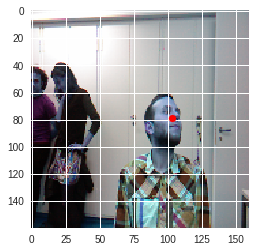

In [36]:
print(x_train.shape)
plt.imshow(x_train[33])
plt.scatter([y_train[33][1]], [y_train[33][0]], c='r')

## Create Image Data Generator with Image Augmentation
We then need to resize the images and create a data generator, to be used for training / validation

For this section, I used an additional source: [here](https://keras.io/preprocessing/image/)

In [0]:
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(x_train, y_train,
                batch_size=batch_size)

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = validation_datagen.flow(x_valid, y_valid,
                batch_size=batch_size)

## Create the base model using a pretrained network
Here we are using MobileNet because it is small, we can always switch to something else later

In [40]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 0s 0us/step


## Model Set-Up
We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting layer.trainable = False), we prevent the weights in these layers from being updated during training.

In [0]:
base_model.trainable = False

In [0]:
# Let's take a look at the base model architecture
base_model.summary()

### Add back the top layers
Now let's add a few layers on top of the base model:

In [0]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(2, activation='relu')
])

### Compile the model
You must compile the model before training it. For this, we will create a new metric, the distance between the ground-truth point and our point

In [0]:
def dist_pred(y_true, y_pred):
    return K.sqrt((y_true[0] - y_pred[0])**2 + (y_true[1] - y_pred[1])**2)

In [50]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='mean_squared_error', 
              metrics=[dist_pred])

Instructions for updating:
Use tf.cast instead.


In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the Model

In [52]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
72/72 [==============================] - 151s 2s/step - loss: 7629.0794 - dist_pred: 123.7456 - val_loss: 6483.3107 - val_dist_pred: 115.9632
Epoch 2/10
72/72 [==============================] - 149s 2s/step - loss: 7017.9424 - dist_pred: 118.3031 - val_loss: 5948.2642 - val_dist_pred: 107.5937
Epoch 3/10
72/72 [==============================] - 150s 2s/step - loss: 6440.6434 - dist_pred: 113.1408 - val_loss: 5415.8781 - val_dist_pred: 103.8795
Epoch 4/10
72/72 [==============================] - 150s 2s/step - loss: 5891.2103 - dist_pred: 107.3692 - val_loss: 5001.9894 - val_dist_pred: 98.2981
Epoch 5/10
72/72 [==============================] - 147s 2s/step - loss: 5370.2030 - dist_pred: 101.6067 - val_loss: 4654.8051 - val_dist_pred: 95.4941
Epoch 6/10
72/72 [==============================] - 149s 2s/step - loss: 4870.9821 - dist_pred: 96.8912 - val_loss: 4141.8204 - val_dist_pred: 93.5183
Epoch 7/10
72/72 [====================